<a href="https://colab.research.google.com/github/pourzand/Facial-Landmark-Detection-with-Deeplabv3-DSNT/blob/main/ashwhall%20Demo%20using%20DeepLabV3%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
# Imports
import tensorflow as tf
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# DeepLab Imports
from keras.layers import Activation,Conv2D,MaxPooling2D,BatchNormalization,Input,DepthwiseConv2D,add,Dropout,AveragePooling2D,Concatenate, Layer,InputSpec
from keras.models import Model														  
import keras.backend as K
# from keras.engine import Layer,InputSpec # This is from old keras/tf, 
from keras.utils import conv_utils


# Differentiable Spatial to Numerical Transform
An example of the usage of the DSNT layer, as taken from the paper "Numerical Coordinate Regression with Convolutional Neural Networks"

In [104]:

# DSNT Function(s)

'''
A Tensorflow implementation of the DSNT layer, as taken from the paper "Numerical Coordinate
Regression with Convolutional Neural Networks"
'''

def dsnt(inputs, method='softmax', output_range='0to1'):
    '''
    Differentiable Spatial to Numerical Transform, as taken from the paper "Numerical Coordinate
    Regression with Convolutional Neural Networks"
    Arguments: 
        inputs - The learnt heatmap. A 4d tensor of shape [batch, height, width, channels]
        method - A string representing the normalisation method. See `_normalise_heatmap` for available methods
        output_range - output range for x,y. please choose "0to1" (inclusive range) or "-1to1" (exclusive range)
            The paper chooses "-1to1" range which includes only numbers between -1 to 1, but exclude -1 and 1.
    Returns:
        norm_heatmap - The given heatmap with normalisation/rectification applied
        coords_zipped - A tensor of shape [batch, channels, 2] containing the [x, y] coordinate pairs for each heatmap
    Example:
        Usage as a Keras layer (ignoring heatmap): `keras.layers.Lambda(lambda x: dsnt.dsnt(x, 'softmax')[1])`
        Should directly follow a Conv2D layer with linear activation.
    '''
    # Rectify and reshape inputs
    norm_heatmap = _normalise_heatmap(inputs, method)
    
    batch_count = tf.shape(norm_heatmap)[0]
    height = tf.shape(norm_heatmap)[1]
    width = tf.shape(norm_heatmap)[2]
    channels = norm_heatmap.shape[3]

    if output_range == '0to1':
        gen_range = lambda length: tf.range(length) / (length-1)
    elif output_range == '-1to1':
        gen_range = lambda length: (2 * tf.range(1, length+1) - (length+1)) / length
    else:
        raise ValueError("Unknown output_range: " + str(output_range))

    # Build the DSNT x, y matrices
    dsnt_x = tf.reshape(gen_range(width), [1, 1, -1, 1])
    dsnt_x = tf.tile(dsnt_x, [batch_count, height, 1, channels])
    dsnt_x = tf.cast(dsnt_x, tf.float32)
    dsnt_y = tf.reshape(gen_range(height), [1, -1, 1, 1])
    dsnt_y = tf.tile(dsnt_y, [batch_count, 1, width, channels])
    dsnt_y = tf.cast(dsnt_y, tf.float32)

    # Compute the Frobenius inner product
    outputs_x = tf.reduce_sum(tf.multiply(norm_heatmap, dsnt_x), axis=[1, 2])
    outputs_y = tf.reduce_sum(tf.multiply(norm_heatmap, dsnt_y), axis=[1, 2])

    # Zip into [x, y] pairs
    coords_zipped = tf.stack([outputs_x, outputs_y], axis=-1)

    return norm_heatmap, coords_zipped

def js_reg_loss(heatmaps, centres, fwhm=1):
    '''
    Calculates and returns the average Jensen-Shannon divergence between heatmaps and target Gaussians.
    Arguments:
        heatmaps - Heatmaps generated by the model
        centres - Centres of the target Gaussians (in normalized units)
        fwhm - Full-width-half-maximum for the drawn Gaussians, which can be thought of as a radius.
    '''
    gauss = _make_gaussians(centres, tf.shape(heatmaps)[1], tf.shape(heatmaps)[2], fwhm)
    divergences = _js_2d(heatmaps, gauss)
    return tf.reduce_mean(divergences)


def _normalise_heatmap(inputs, method='softmax'):
    '''
    Applies the chosen normalisation/rectification method to the input tensor
    Arguments:
        inputs - A 4d tensor of shape [batch, height, width, channels] (the learnt heatmap)
        method - A string representing the normalisation method. One of those shown below
    '''
    # Remove the final dimension as it's of size 1
#     inputs = tf.reshape(inputs, tf.shape(inputs)[:3])

    # Normalise the values such that the values sum to one for each heatmap
    normalise = lambda x: tf.divide(x, tf.reduce_sum(x, axis=[1, 2], keepdims=True))

    # Perform rectification
    if method == 'softmax':
        inputs = _softmax2d(inputs, axes=[1, 2])
    elif method == 'abs':
        inputs = tf.abs(inputs)
        inputs = normalise(inputs)
    elif method == 'relu':
        inputs = tf.nn.relu(inputs)
        inputs = normalise(inputs)
    elif method == 'sigmoid':
        inputs = tf.nn.sigmoid(inputs)
        inputs = normalise(inputs)
    else:
        msg = "Unknown rectification method \"{}\"".format(method)
        raise ValueError(msg)
    return inputs

def _kl_2d(p, q, eps=24):
    unsummed_kl = p * (tf.log(p + eps) - tf.log(q + eps))
    kl_values = tf.reduce_sum(unsummed_kl, [-1, -2])
    return kl_values

def _js_2d(p, q, eps=1e-24):
    m = 0.5 * (p + q)
    return 0.5 * _kl_2d(p, m, eps) + 0.5 * _kl_2d(q, m, eps)

def _softmax2d(target, axes):
    '''
    A softmax implementation which can operate across more than one axis - as this isn't
    provided by Tensorflow
    Arguments:
        targets - The tensor on which to apply softmax
        axes - An integer or list of integers across which to apply softmax
    '''
    max_axis = tf.reduce_max(target, axes, keepdims=True)
    target_exp = tf.exp(target-max_axis)
    normalize = tf.reduce_sum(target_exp, axes, keepdims=True)
    softmax = target_exp / normalize
    return softmax

def _make_gaussian(size, centre, fwhm=1):
        '''
        Makes a rectangular gaussian kernel.
        Arguments:
            size - A 2d tensor representing [height, width]
            centre - Pair of (normalised [0, 1]) x, y coordinates 
            fwhm - Full-width-half-maximum, which can be thought of as a radius.
        '''
        # Scale the normalised coordinates to be relative to the size of the frame
        centre = [centre[0] * tf.cast(size[1], tf.float32), 
                  centre[1] * tf.cast(size[0], tf.float32)]
        # Find the largest side, as we build a square and crop to desired size
        square_size = tf.cast(tf.reduce_max(size), tf.float32)

        x = tf.range(0, square_size, 1, dtype=tf.float32)
        y = x[:,tf.newaxis]
        x0 = centre[0] - 0.5
        y0 = centre[1] - 0.5
        unnorm = tf.exp(-4*tf.log(2.) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)[:size[0],:size[1]]
        norm = unnorm / tf.reduce_sum(unnorm)
        return norm

def _make_gaussians(centres_in, height, width, fwhm=1):
    '''
    Makes a batch of gaussians. Size of images designated by height, width; number of images
    designated by length of the 1st dimension of centres_in
    Arguments:
        centres_in - The normalised coordinate centres of the gaussians of shape [batch, x, y]
        height - The desired height of the produced gaussian image
        width - The desired width of the produced gaussian image
        fwhm - Full-width-half-maximum, which can be thought of as a radius.
    '''
    def cond(centres, heatmaps):
        return tf.greater(tf.shape(centres)[0], 0)
    
    def body(centres, heatmaps):
        curr = centres[0]
        centres = centres[1:]
        new_heatmap = _make_gaussian([height, width], curr, fwhm)
        new_heatmap = tf.reshape(new_heatmap, [-1])
        
        heatmaps = tf.concat([heatmaps, new_heatmap], 0)
        return [centres, heatmaps]
    
    # Produce 1 heatmap per coordinate pair, build a list of heatmaps
    _, heatmaps_out = tf.while_loop(cond,
                                    body,
                                    [centres_in, tf.constant([])],
                                    shape_invariants=[tf.TensorShape([None, 2]), tf.TensorShape([None])])
    heatmaps_out = tf.reshape(heatmaps_out, [-1, height, width])
    return heatmaps_out

## Build some dummy data
Circles of random colour, size and position on a black background


200 images total
training: 150
testing : 50


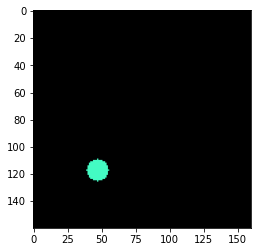

In [105]:
img_size = 160
image_count = 200
train_percent = 0.75
train_image_count = int(train_percent * image_count)
test_image_count = image_count - train_image_count

np.random.seed(0)


images = []
targets = []
for _ in range(200):
    img = np.zeros((img_size, img_size, 3))
    row, col = np.random.randint(0, img_size), np.random.randint(0, img_size)
    radius = np.random.randint(8, 15)
    b, g, r = np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)
    cv2.circle(img, (row, col), radius, (b, g, r), -1)
    images.append(img)
    norm_row = row / img_size
    norm_col = col / img_size
    targets.append([norm_row, norm_col])

images = np.array(images)
targets = np.array(targets)
train_images = images[:train_image_count]
test_images = images[train_image_count:]
train_targets = targets[:train_image_count]
test_targets = targets[train_image_count:]

print('''
{} images total
training: {}
testing : {}'''.format(image_count, train_image_count, test_image_count))

plt.imshow(train_images[0].astype('uint8'))

In [108]:

print(train_targets.shape)
print(train_targets[0])
# train_targets = np.resize(train_targets, (train_targets.shape[0],4))
num_classes =1 # aka the number of landmarks per image, in this case just 1 landmark since the landmark is 1 dot
train_targets = train_targets.reshape(train_targets.shape[0],num_classes,2)

print(train_targets.shape)
print("old train {}".format(train_targets[0][0]))
print("old train {}".format(train_targets[1][0]))

print(train_targets[:].shape)
# train_targets[0] = np.tile(train_targets[0],(1,2))
backgroundcoords = np.full([150,1,2],.5)
train_targets = np.append(train_targets,backgroundcoords,1)

print(train_targets.shape)

print("new train {}".format(train_targets[0][0]))

print("new train {}".format(train_targets[1][0]))
print("new train2 {}".format(train_targets[0][1]))





# data should now be compatible with the deeplabv3 model

(150, 1, 2)
[[0.29375 0.73125]]
(150, 1, 2)
old train [0.29375 0.73125]
old train [0.64375 0.05625]
(150, 1, 2)
(150, 2, 2)
new train [0.29375 0.73125]
new train [0.64375 0.05625]
new train2 [0.5 0.5]


In [109]:
print(train_targets.shape)
print(train_targets[0][0])

(150, 2, 2)
[0.29375 0.73125]


##  U-Net Model
Fully Connected Network with the final layer being the DSNT layer through the use of a keras lambda layer

In [110]:
import keras
from keras import layers

def uNetModel(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same",name ="last")(x)
    print("preDSNT {}".format(outputs.shape))

    #DSNT
    outputs = tf.keras.layers.Lambda(lambda x: dsnt(x, 'softmax')[1])(outputs)
    print("postDSNT {}".format(outputs.shape))

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()


In [111]:
def fcnModel(input_shape=(160,160,3),out_stride=16,num_classes=1):
	
	img_input=Input(shape=input_shape) # OG
	print("input shape is the following: {} {} {}".format(input_shape[0], input_shape[1],input_shape[2]))
	#print(input_shape[0], input_shape[1],input_shape[2]) # not OG
	# img_input = tf.compat.v1.placeholder(tf.float32, shape=[None, input_shape[0], input_shape[1],input_shape[2]]) # Not OG

	x=Conv2D(32,(3,3),strides=(2,2),padding="same",use_bias=False)(img_input)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
	x=Conv2D(64,(3,3),padding="same",use_bias=False)(x)
	x=BatchNormalization()(x)
	x=Activation("relu")(x)
    
    
	x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
# 	inputs = tf.keras.layers.Conv2D(filters=166,
#                         kernel_size=3,
#                         dilation_rate=1,
#                         padding='SAME',
#                         name='conv1')(img_input)
# 	inputs = tf.nn.relu(inputs)
# 	inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
# 	inputs = tf.keras.layers.Conv2D(filters=32,
#                         kernel_size=3,
#                         dilation_rate=2,
#                         padding='SAME',
#                         name='conv2')(inputs)
# 	inputs = tf.nn.relu(inputs)
# 	inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
# 	inputs = tf.keras.layers.Conv2D(filters=64,
#                         kernel_size=3,
#                         dilation_rate=4,
#                         padding='SAME',
#                         name='conv3')(inputs)
# 	inputs = tf.nn.relu(inputs)
# 	inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
	inputs = tf.keras.layers.Conv2D(filters=128,
                        kernel_size=3,
                        dilation_rate=8,
                        padding='SAME',
                        name='conv4')(x) # used to be 'inputs'
	inputs = tf.nn.relu(inputs)
	inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
	inputs = tf.keras.layers.Conv2D(filters=256,
                        kernel_size=3,
                        dilation_rate=16,
                        padding='SAME',
                        name='conv5')(inputs)
	inputs = tf.nn.relu(inputs)
	inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
	inputs = tf.keras.layers.Conv2D(filters=256,
                        kernel_size=3,
                        padding='SAME',
                        name='conv6')(inputs)
	inputs = tf.nn.relu(inputs)
	inputs = tf.nn.max_pool(inputs, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    
	inputs = tf.keras.layers.Conv2D(filters=1,
                        kernel_size=1,
                        padding='SAME',
                        name='last2')(inputs)
	temp = tf.nn.relu(inputs,name='last3')

	print("----------------")
	print("final shape of fcn model {}".format(inputs.shape))
	print("----------------")
	
#
	x = tf.keras.layers.Lambda(lambda x: dsnt(inputs, 'softmax')[1])(temp)
	model=Model(img_input,x)
	

	
	return model

## Training
A very simple training loop with no mini-batching.

In [112]:
tf.compat.v1.disable_eager_execution()

model = uNetModel(img_size=(160,160),num_classes=2) # segments into background and foreground i think
# this specific u-net def will add 3 channels to input size automatically
model.summary()

#model.summary()
fcnBasic = fcnModel(input_shape=(160,160,3),out_stride=16,num_classes=1)
#fcnBasic.summary()


preDSNT (None, 160, 160, 2)
postDSNT (None, 2, 2)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                            

In [113]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# to Stop training if there is no improvements

model.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])


model.fit(train_images, train_targets, batch_size=16, epochs=25, callbacks=[callback])
                            
inputs = model.input   
outputs= model.get_layer('last').output

pureUnet = Model(inputs,outputs)


Train on 150 samples
Epoch 1/25
150/150 [==============================] - 5s 35ms/sample - loss: 0.0283 - accuracy: 0.7133
Epoch 2/25
150/150 [==============================] - 2s 16ms/sample - loss: 0.0261 - accuracy: 0.7333
Epoch 3/25
150/150 [==============================] - 3s 17ms/sample - loss: 0.0259 - accuracy: 0.7400
Epoch 4/25
150/150 [==============================] - 2s 15ms/sample - loss: 0.0259 - accuracy: 0.7333
Epoch 5/25
150/150 [==============================] - 2s 15ms/sample - loss: 0.0260 - accuracy: 0.7267
Epoch 6/25
150/150 [==============================] - 2s 16ms/sample - loss: 0.0259 - accuracy: 0.7333


In [20]:
fcnBasic.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['accuracy'])


fcnBasic.fit(train_images, train_targets, batch_size=16, epochs=25)


Train on 150 samples
Epoch 1/25
150/150 [==============================] - 2s 10ms/sample - loss: 0.0103 - accuracy: 0.9200
Epoch 2/25
150/150 [==============================] - 1s 8ms/sample - loss: 0.0034 - accuracy: 0.9600
Epoch 3/25
150/150 [==============================] - 1s 8ms/sample - loss: 0.0028 - accuracy: 0.9733
Epoch 4/25
150/150 [==============================] - 1s 7ms/sample - loss: 0.0014 - accuracy: 0.9400
Epoch 5/25
150/150 [==============================] - 1s 7ms/sample - loss: 8.3994e-04 - accuracy: 0.9533
Epoch 6/25
150/150 [==============================] - 1s 7ms/sample - loss: 6.8369e-04 - accuracy: 0.9733
Epoch 7/25
150/150 [==============================] - 1s 7ms/sample - loss: 4.0892e-04 - accuracy: 0.9733
Epoch 8/25
150/150 [==============================] - 1s 7ms/sample - loss: 3.1764e-04 - accuracy: 0.9733
Epoch 9/25
150/150 [==============================] - 1s 7ms/sample - loss: 2.3501e-04 - accuracy: 0.9867
Epoch 10/25
150/150 [===================

In [114]:
test_targets = test_targets.reshape(test_targets.shape[0],num_classes,2)

backgroundcoords2 = np.full([50,1,2],.5)
test_targets = np.append(test_targets,backgroundcoords2,1)

results = model.evaluate(test_images, test_targets, batch_size=16)
print("test loss, test acc:", results)

/Users/seena/miniforge3/envs/seenaTest/lib/python3.9/site-packages/keras/engine/training_v1.py:2045: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


test loss, test acc: [0.03455286279320717, 0.79999995]


In [115]:
predicts = pureUnet.predict(test_images)
print(predicts.shape)


fcnIn = fcnBasic.input
fcnOut = fcnBasic.get_layer('last2').output
fcnHeat = Model(fcnIn,fcnOut) 
earlyPredict = fcnHeat.predict(test_images)
print(earlyPredict.shape)

actPredicts = model.predict(test_images)


/Users/seena/miniforge3/envs/seenaTest/lib/python3.9/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


(50, 160, 160, 2)
(50, 5, 5, 1)


In [128]:
newPredicts = np.einsum('ijkl->iljk',predicts )
print(actPredicts.shape)
print(160* actPredicts[5][0])

(50, 2, 2)
[68.625015 84.95471 ]


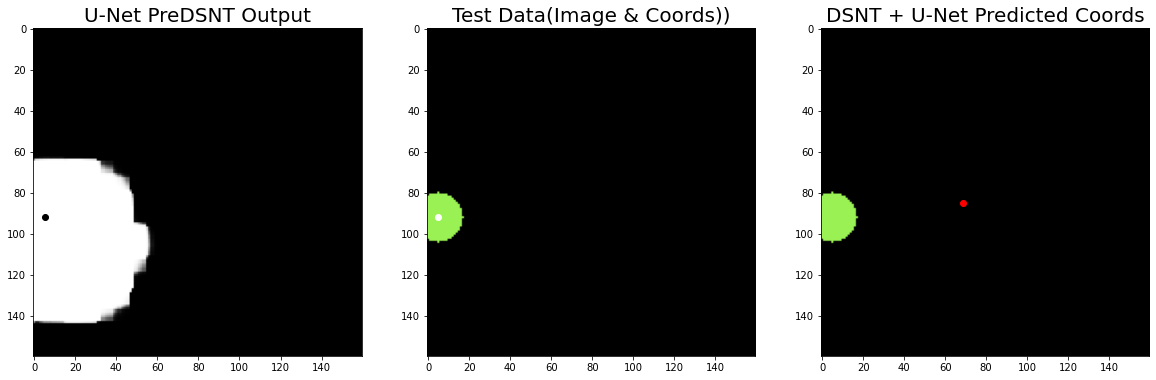

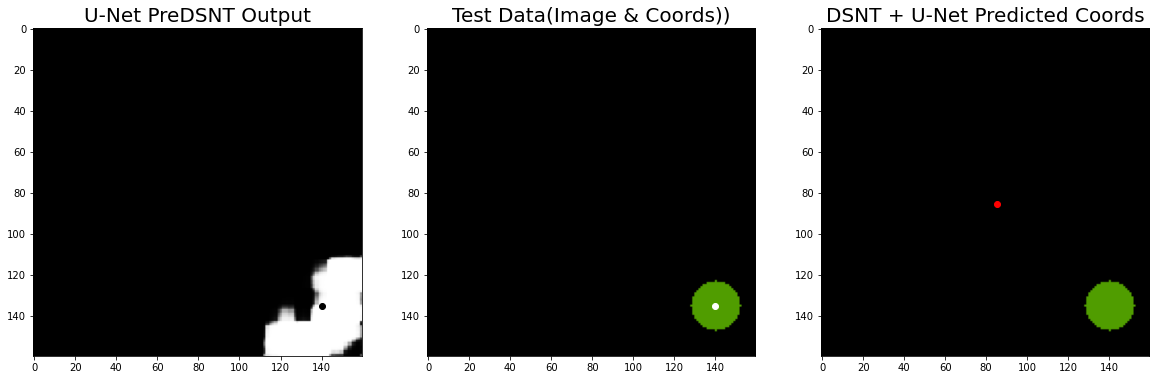

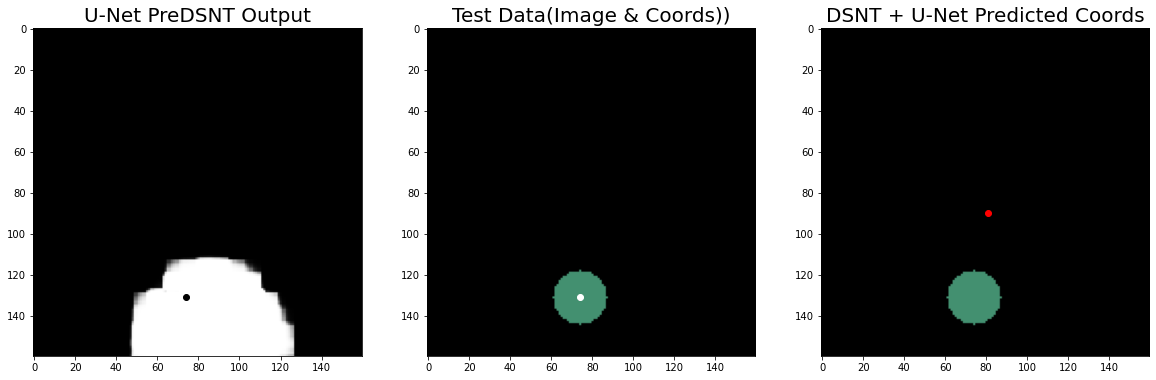

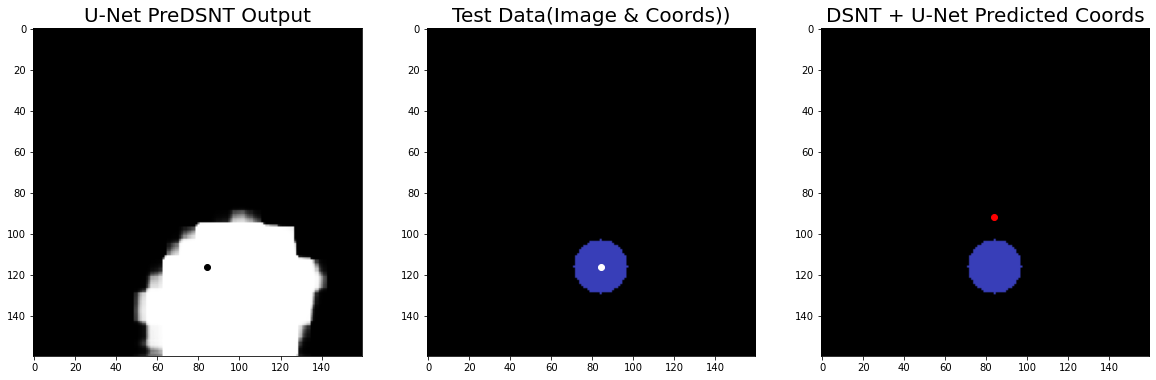

In [121]:

for numImage in range(5,9):
    f, ax = plt.subplots(1, 3, figsize=(20,20))   
    ax[0].imshow((newPredicts[numImage][0]),cmap="gray")
    ax[0].scatter((160 * test_targets[numImage][0][0]),(160 * test_targets[numImage][0][1]),c = 'black')
    ax[0].set_title( "U-Net PreDSNT Output", fontsize=20)

    ax[1].imshow(test_images[numImage].astype('uint8'))
    ax[1].scatter((160 * test_targets[numImage][0][0]),(160 * test_targets[numImage][0][1]),c = 'white')
    ax[1].set_title( "Test Data(Image & Coords))", fontsize=20)

    ax[2].imshow(test_images[numImage].astype('uint8'))
    ax[2].scatter((160 * actPredicts[numImage][0][0]),(160 * actPredicts[numImage][0][1]),c = 'red')
    ax[2].set_title( "DSNT + U-Net Predicted Coords", fontsize=20)

# Above on the left is the output of a deeplab segmentation when fed in the dots and the coordinates of the dots. Dot is plotted as well for reference. Right is example of training data appearance and the corresponding coordinate as well as deeplabv3 predicted coordinate in red

## It is a bit hard to tell but in some of the DeepLab segmentation pre DSNT plots, there is a very faint highlight around the points, so the deeplab is detecting the points but it is also detects the edges much more(shown with the bright white lines around the border of every image) which is what I suspect is causing it to continually plot points in the center

#### To take away these bright white lines which highlight the borders/edges of the image, which i suspect are warping the dsnt predictions, I crop the image slightly to remove the bright white edges, and then replace it with zero padding so the image remains the same size. Yes, this would affect any cases where the point might be near the edge, but this is purely for debugging purposes

Argmax Predict for Image 6
(17, 65)
Actual Coord for Image 6
5.0 92.0
_____________________
Argmax Predict for Image 7
(147, 120)
Actual Coord for Image 7
140.0 135.0
_____________________
Argmax Predict for Image 8
(83, 120)
Actual Coord for Image 8
74.0 131.0
_____________________
Argmax Predict for Image 9
(95, 96)
Actual Coord for Image 9
84.0 116.0
_____________________


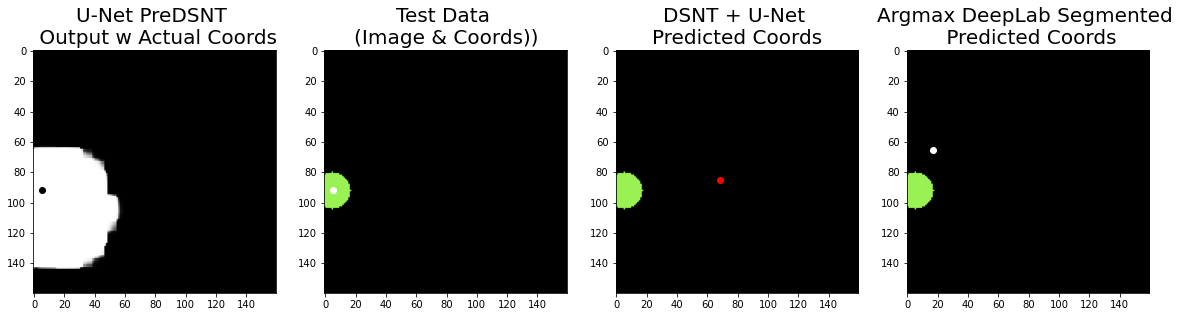

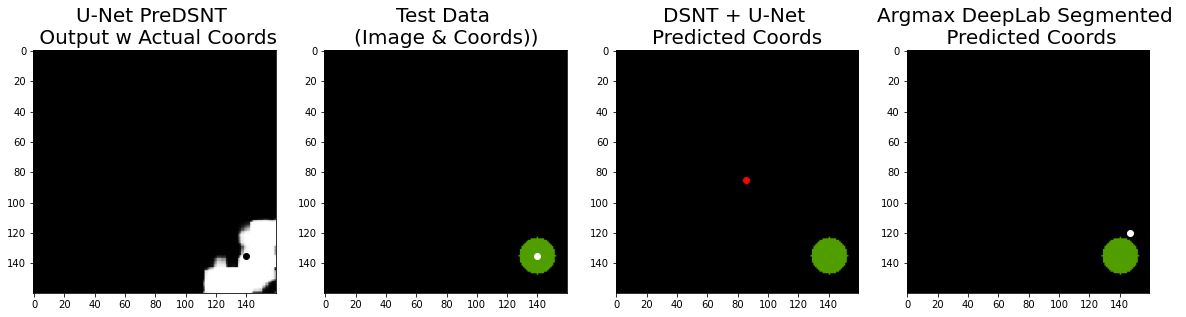

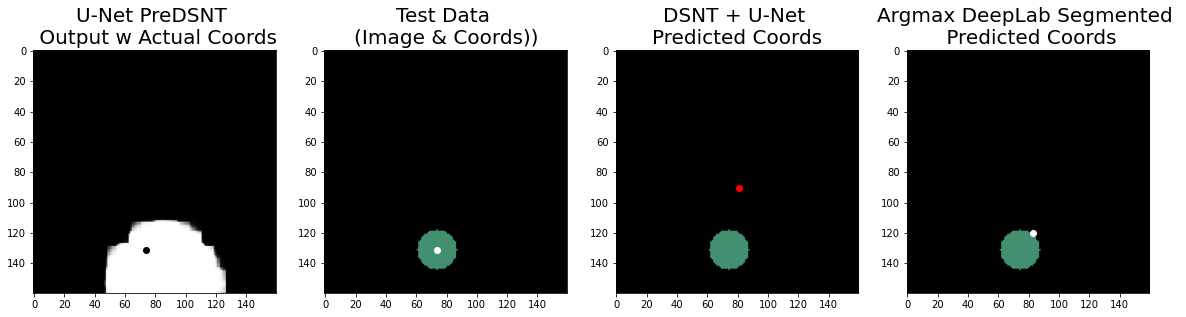

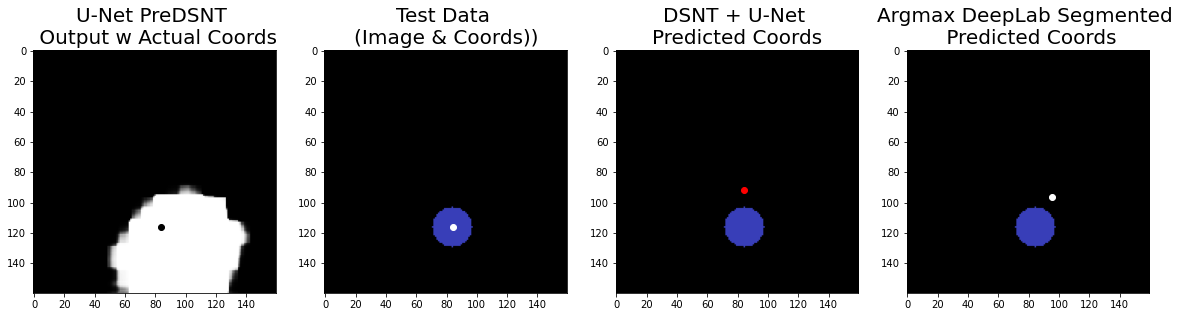

In [129]:
for numImage in range(5,9):
    f, ax = plt.subplots(1, 4, figsize=(20,20))   
    # tempArr = newPredicts[numImage][0][8:152, 8:152]
    # tempArr = np.pad(tempArr, 8,constant_values = 0.0011) # the value of 0.0011 just makes it more visible to see the heatmap 
    # tempArr *= 1

    # used to be (newPredicts[numImage][0])
    ax[0].imshow(newPredicts[numImage][0],cmap="gray")
    ax[0].scatter((160 * test_targets[numImage][0][0]),(160 * test_targets[numImage][0][1]),c = 'black')
    ax[0].set_title( "U-Net PreDSNT \n Output w Actual Coords", fontsize=20)


    ax[1].imshow(test_images[numImage].astype('uint8'))
    ax[1].scatter((160 * test_targets[numImage][0][0]),(160 * test_targets[numImage][0][1]),c = 'white')
    ax[1].set_title( "Test Data \n(Image & Coords))", fontsize=20)


    ax[2].imshow(test_images[numImage].astype('uint8'))
    ax[2].scatter((160 * actPredicts[numImage][0][0]),(160 * actPredicts[numImage][0][1]),c = 'red')
    ax[2].set_title( "DSNT + U-Net \nPredicted Coords", fontsize=20)
    
    # tempArr[10:150, 10:150] *= 10 # Just so we can make sure the highlighted parts of output have the greatest value
    
    tempCoords = np.unravel_index(np.argmax(newPredicts[numImage][0], axis=None), newPredicts[numImage][0].shape,order='F')
    
    ax[3].imshow(test_images[numImage].astype('uint8'))
    ax[3].scatter((tempCoords[0]),(tempCoords[1]),c = 'white')
    ax[3].set_title( "Argmax DeepLab Segmented \n Predicted Coords", fontsize=20)
    
    print("Argmax Predict for Image {}".format(numImage+1))
    print(np.unravel_index(np.argmax(newPredicts[numImage][0], axis=None), newPredicts[numImage][0].shape,order='F'))
    print("Actual Coord for Image {}".format(numImage+1))
    print((160 * test_targets[numImage][0][0]),(160 * test_targets[numImage][0][1]))
    print("_____________________")

## So from what I can tell the weird bright edges were affected the DSNT calculation, causing it to always 

(50, 5, 5, 1)
[-2.8192096]


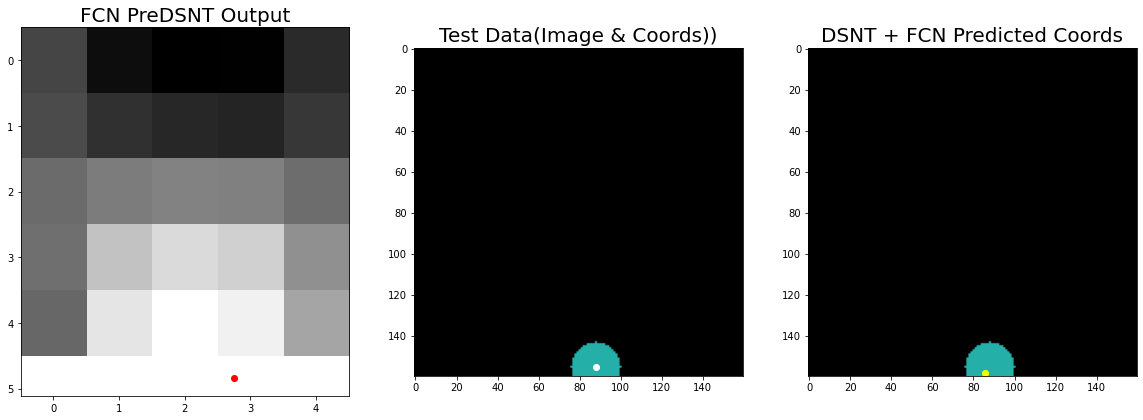

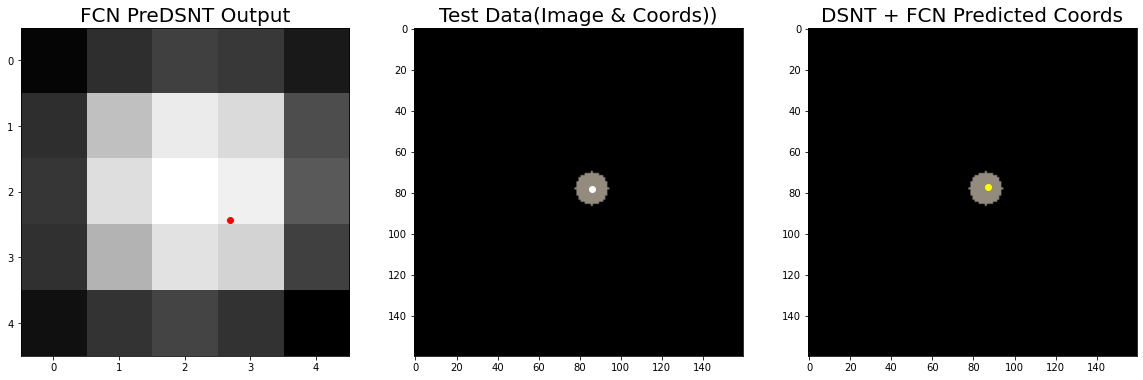

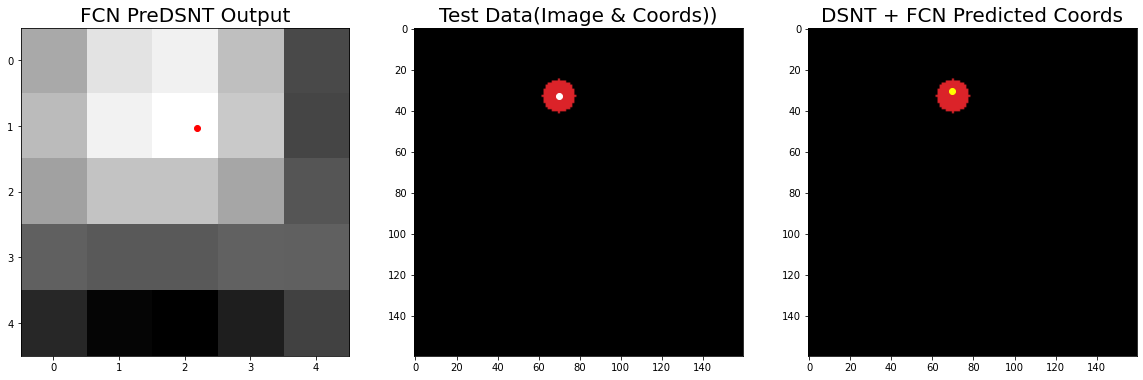

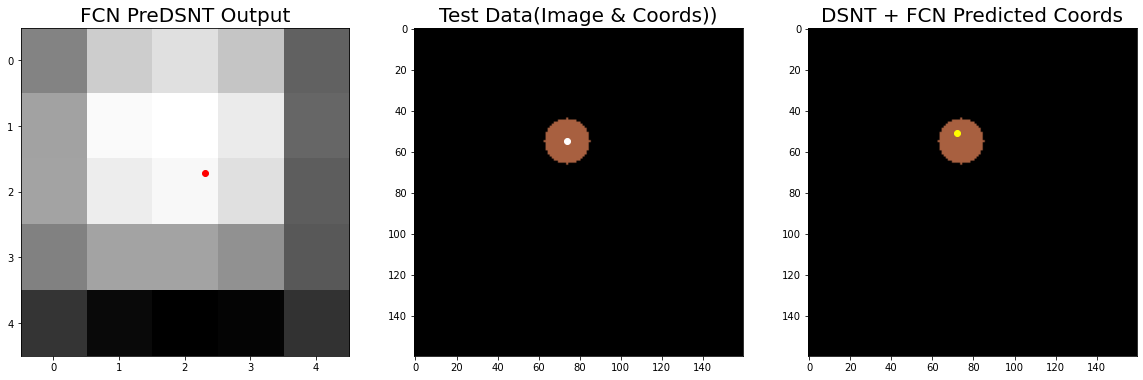

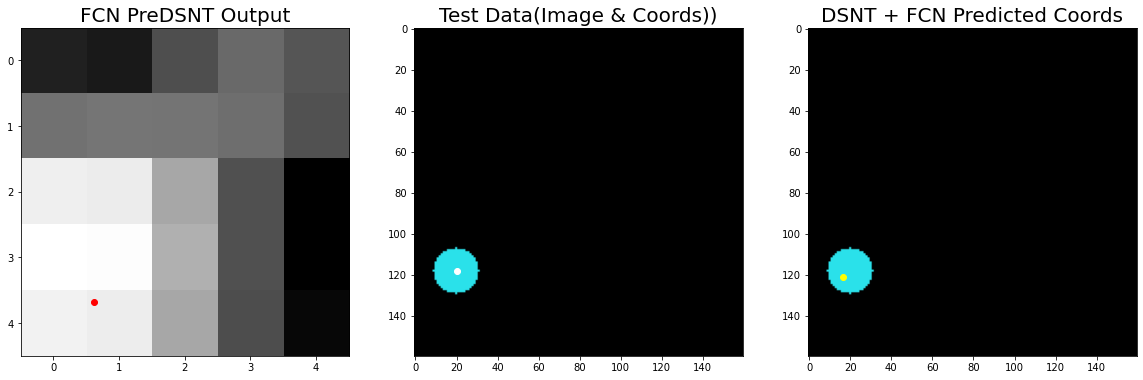

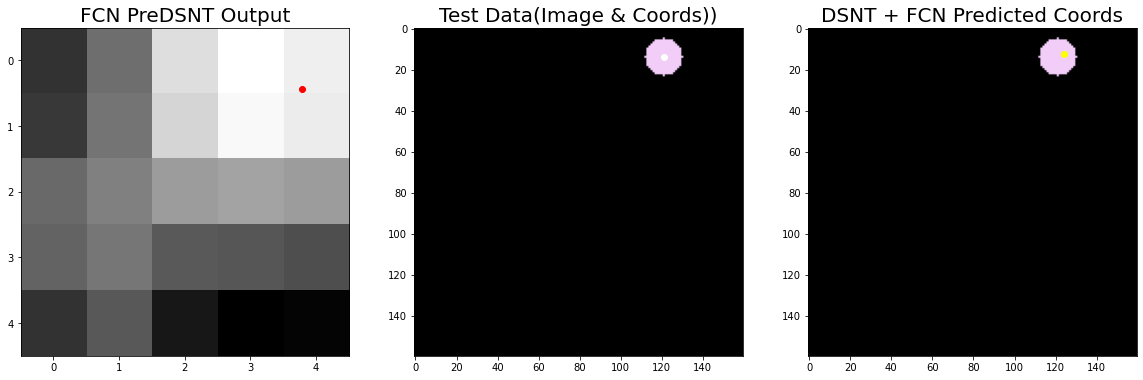

In [49]:
print(earlyPredict.shape)
print(earlyPredict[0][0][0])

fcnPredicts = fcnBasic.predict(test_images)

# f, ax = plt.subplots(1, 2, figsize=(20,20))

# ax[0].imshow((earlyPredict[0]),cmap="gray")
# ax[0].scatter((5 * test_targets[0][0][0]),(5 * test_targets[0][0][1]),c = 'red')

# ax[1].imshow(test_images[0].astype('uint8'))
# ax[1].scatter((160 * test_targets[0][0][0]),(160 * test_targets[0][0][1]),c = 'white')


for numImage in range(6):
    f, ax = plt.subplots(1, 3, figsize=(20,20))

    ax[0].imshow((earlyPredict[numImage]),cmap="gray")
    ax[0].scatter((5 * test_targets[numImage][0][0]),(5 * test_targets[numImage][0][1]),c = 'red')
    ax[0].set_title( "FCN PreDSNT Output", fontsize=20)


    ax[1].imshow(test_images[numImage].astype('uint8'))
    ax[1].scatter((160 * test_targets[numImage][0][0]),(160 * test_targets[numImage][0][1]),c = 'white')
    ax[1].set_title( "Test Data(Image & Coords))", fontsize=20)


    ax[2].imshow(test_images[numImage].astype('uint8'))
    ax[2].scatter((160 * fcnPredicts[numImage][0][0]),(160 * fcnPredicts[numImage][0][1]),c = 'yellow')
    ax[2].set_title( "DSNT + FCN Predicted Coords", fontsize=20)



# Above on the left is the output of a basic fcn segmentation when fed in the dots and the coordinates of the dots. Dot is plotted as well for reference. right is example of training data appearance and the corresponding coordinate as well as fcn predicted coordinate in yellow 